# Coding of TD($\lambda$) learner algorithm

In [23]:
from platform import python_version
python_version()

'3.7.4'

In [24]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Based on Chapter 12: Eligibility Traces from Sutton & Barto

### TD($\lambda$)

<IMG SRC="images/tdlambda.png">

## Random Walk Environment

Use the same random walk environment used in Chapter 7 (Example 7.1)

This has been implemented in a separate module `randomwalk.py`

In [25]:
from randomwalk import RandomWalkGame

In [26]:
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})

In [27]:
# Initial state
game.show_state()

T1 _ _ _ _ _ _ _ _ _ J _ _ _ _ _ _ _ _ _ T2


In [28]:
# Moves are 'l' or 'r' (left or right)
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ _ _ _ _ _ _ K _ _ _ _ _ _ _ _ T2


In [29]:
# zero rewards...
game.get_rewards()

{1: 0.0}

In [30]:
# until terminal state reached
while not game.state in game.terminal_states:
    game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ T2


In [31]:
game.get_terminal_rewards()

{1: 1.0}

## Objective

For verification purposes, let's try to replicate the results below which should match Figure 12.8 from the book which looks like this:

<IMG SRC="images/fig_12_8.png">    

Recap: this is the n-step TD update method from chapter 7

## N-Step TD Update - for comparison

In [32]:
def discounted_sequence_generator(sequence, gamma):
    """Returns a generator that yields each item of sequence
    discounted by gamma at each time-step.
    
    Example:
    >>> list(discounted_sequence_generator([10.0]*5, 0.75))
    [10.0, 7.5, 5.625, 4.21875, 3.1640625]
    """

    x = 1.0
    for item in sequence:
        yield x * item
        x = x * gamma


def td_n_step_update(n, value_function, prev_states, prev_rewards, tau, gamma,
                     learning_rate, t_max=np.inf, show=False):
    """Updates the value in value_function for the state
    that occurred in past timestep tau using the n-step TD
    algorithm.
    
    Note:
    tau = t - n + 1

    Where:
        t is the current timestep
        n is the number of steps to look forward  

    If tau < 0 no update is possible so none is made.

    Args:
        value_function (dict): Dictionary of state values.
        prev_states (list): List of previous states.
        prev_rewards (list): List of previous rewards.
        tau (int): The timestep of the state that will have
            its value updated.
        gamma (float): Discount rate.
        learning_rate (float): Learning rate parameter.
        t_max (int or np.inf): The maximum timestep to include.  
            Set to np.inf or a high number if you want to
            include all timesteps from tau to tau + n.  Set
            to t if the game has eneded.
        show (bool): Print messages if True.
    """

    assert len(prev_states) == len(prev_rewards)

    if tau >= 0:

        assert tau < len(prev_states), "Not enough past states."

        discounted_rewards = discounted_sequence_generator(
            prev_rewards[tau+1:min(tau + n, t_max) + 1], 
            gamma
        )
        g = sum(list(discounted_rewards))

        if tau + n < t_max:
            g += gamma**n * value_function[prev_states[tau + n]]

        # Update value of state at timestep tau
        state_key = prev_states[tau]
        state_value = value_function[state_key]

        if show:
            print(f"prev_states[{tau}]: {state_value}")

        value_function[state_key] = state_value + \
            learning_rate * (g - state_value)

        if show:
            print(f"value_function[{state_key.__repr__()}]: {value_function[state_key]}")


Here is the equivalent TD($\lambda$) update calculation

## TD($\lambda$)

In [33]:
def td_lambda_weight_update(weights, value_current_state, value_prev_state, reward, 
                            dv_dw, z, lam, gamma, learning_rate):
    """Updates the weights of a value function for the 
    previous state using the TD-Lambda algorithm.
    
    Args:
        weights (array): Array of weights (value function 
            parameters).
        value_current_state (float): Value estimate for current state.
        value_prev_state (float): Value estimate for previous state.
        reward (float): Reward at current state.
        dv_dw (array): Partial derivatives of value function
            w.r.t. the weights at current state.
        z (array): Eligibility trace vector.
        lam (float): Lambda parameter.
        gamma (float): Discount factor.
        learning_rate (float): Learning rate parameter.
    """

    assert dv_dw.shape == z.shape
    z = gamma * lam * z + dv_dw
    td_error = reward + gamma * value_current_state - value_prev_state
    
    return weights + learning_rate * td_error * z


In [34]:
# Compare to this code from here:
# https://amreis.github.io/ml/reinf-learn/2017/11/02/reinforcement-learning-eligibility-traces.html
#
# td_error = reward + gamma * state_values[new_state] - state_values[state]
# state_values = state_values + alpha * td_error * eligibility

# Run The Parameter Search

### Initialize Random-Walk Environment

In [35]:
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
n_states = len(game.states) - len(game.terminal_states)
n_states

19

## RMS Error Calculation and True Values

This function calculates the true state values (for a random policy)

In [36]:
def calculate_true_values(game):
    """Returns a list of the true values of states in a
    RandomWalk game.
    """

    xp = [0, game.size+1]
    fp = [-1.0, 1.0]

    true_values = np.interp(np.arange(game.size + 2), xp, fp)[1:-1]
    
    return true_values


def calculate_rms_error(values, true_values):
    """Root-mean-squared error of values compared to true values.
    """

    return np.sqrt(np.sum((np.array(values) - 
                           np.array(true_values))**2)/len(values))

# Test true values are correct
true_values = calculate_true_values(game)
values = np.zeros(n_states)
error = calculate_rms_error(values, true_values)
assert error == 0.5477225575051662  # Calculated using code from Sutton & Barto

print(true_values)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


## Value Approximation Functions for use with TD-$\lambda$

To use TD-$\lambda$ we need a differentiable value function applicable to the problem (i.e. the environment's states and actions).  Here are a couple of general-purpose value function classes that might be useful for the RandomWalk environment.

In [37]:
# Simplest possible value function - discrete values for each state
n_states = len(game.states)
state_values = np.zeros(n_states)  # initial guess = 0 value
eligibility = np.zeros(n_states)

## (a) N-Step TD Updates

In [22]:
def run_random_walk_with_n_step_td(n=10, learning_rate=0.01, gamma=1.0, n_episodes=10, 
                                   n_reps=1, initial_value=0.0, size=19, seed=1):
    """Run n_episodes of random walk and calculate the root-
    mean-squared errror of the value function after the 
    last episode.  If n_reps > 1 then the experiment is 
    repeated n_reps times and the average rms_error returned.
    """

    # Initialize environment
    terminal_rewards = {'T1': -1.0, 'T2': 1.0}
    game = RandomWalkGame(size=size, terminal_rewards=terminal_rewards)

    # Initialise value function
    value_function = {
        s: 0.0 if s in game.terminal_states else initial_value
        for s in game.states
    }

    # Random number generator
    rng = random.Random(seed)

    # Repeat n_reps times
    rms_errors = []
    for repetition in range(n_reps):
        for iteration in range(n_episodes):

            past_states = [game.state]
            past_rewards = [None]

            T = 999999
            t = 0
            while True:

                # Behaviour policy
                if t < T:
                    move = rng.choice(game.available_moves())
                    game.make_move([1, move])
                    past_states.append(game.state)
                    if not game.game_over:
                        reward = game.get_rewards()[1]
                    else:
                        reward = game.get_terminal_rewards()[1]
                    past_rewards.append(reward)
                    if game.game_over:
                        T = t + 1

                if not game.game_over:
                    # State to be updated
                    tau = t - n + 1
                    td_n_step_update(n, value_function, past_rewards, past_rewards, tau, 
                                     gamma, learning_rate)

                else:
                    # Complete final state-value updates for timesteps tau
                    # to current (terminal) timestep
                    T = t + 1
                    for tau in range(t - n + 1, T):
                        td_n_step_update(n, value_function, past_rewards, past_rewards, tau, 
                                         gamma, learning_rate, t_max=T)

                t += 1
                if tau == T - 1:
                    break
            game.reset()

        values = np.array(list(value_function.values())[1:size+1])
        rms_error = calculate_rms_error(values, true_values)
        rms_errors.append(rms_error)

    avg_rms_error = np.array(rms_errors).mean()

    # Return param values
    params = {
        'n': n,
        'learning_rate': learning_rate,
        'gamma': gamma,
        'n_episodes': n_episodes
    }

    return params, avg_rms_error

# Test
run_random_walk_with_n_step_td()

AssertionError: 

In [19]:
# Run many repetitions with varying parameter values
n_reps = 1

# all possible steps
n_steps_values = np.power(2, np.arange(0, 10))

# all possible alphas
alpha_values = np.arange(0, 1.1, 0.1)

# Use this dictionary to accumulate the results
avg_rms_errors = {}

print(f"Running experiments...")
for n_steps in n_steps_values:
    print(f"n: {n_steps}")
    for alpha in alpha_values:
        params, avg_rms_error = run_random_walk_with_n_step_td(n=n_steps, learning_rate=alpha, 
                                                               n_reps=n_reps, size=n_states)
        avg_rms_errors[tuple(params.items())] = avg_rms_error

print(f"{len(avg_rms_errors)} results calculated")

param_values = [dict(x) for x in avg_rms_errors.keys()]
rms_error_values = list(avg_rms_errors.values())
results_df = pd.concat([pd.DataFrame(param_values), 
                        pd.Series(rms_error_values, name='RMS error')], 
                       axis=1)
results_df.head()

Running experiments...
n: 1


NameError: name 'prev_states' is not defined

In [21]:
print(f"{len(avg_rms_errors)} results calculated")

param_values = [dict(x) for x in avg_rms_errors.keys()]
rms_error_values = list(avg_rms_errors.values())
results_df = pd.concat([pd.DataFrame(param_values), 
                        pd.Series(rms_error_values, name='RMS error')], 
                       axis=1)
results_df.head()

110 results calculated


,n,learning_rate,gamma,n_episodes,RMS error
0,1,0.0,1.0,10,0.547723
1,1,0.1,1.0,10,0.088929
2,1,0.2,1.0,10,0.133378
3,1,0.3,1.0,10,0.182382
4,1,0.4,1.0,10,0.232419


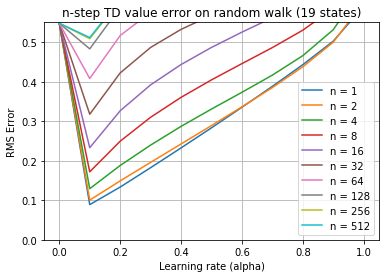

In [23]:
# Plot results
results_by_n_value = results_df.groupby('n')
fig, ax = plt.subplots()
for n, df in results_by_n_value:
    rms_errors = df['RMS error']
    learning_rates = df['learning_rate']
    ax.plot(learning_rates, rms_errors, label=f'n = {n:d}')
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
plt.savefig(f"random-walk-n-step-td-{game.size}-{n_reps}.pdf")
plt.show()

### More interesting function approximation methods

In [ ]:
# Can we use or adapt scikit-learn models?

from sklearn.linear_model import LinearRegression

In [ ]:
from abc import ABC, abstractmethod

class FunctionApproximator(ABC):
    """Abstract function approximation class."""

    def __init__(self, input_shape, d, output_shape=(1,),
                 init_value=0):
        
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.d = d
        self._weights = np.full(d, init_value)

    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, values):
        self._weights[:] = values

    @abstractmethod
    def __call__(self, x):
        """Returns the function estimate at x. x may
        be a single point or sequence of points.
        """
        raise NotImplementedError
    
    @abstractmethod
    def dw(self, x):
        """Returns the partial derivatives w.r.t. the weights
        (parameters) at x.
        """
        raise NotImplementedError


class LinearValueFunctionForDiscreteStates(FunctionApproximator):
    """Uses the following simple linear functon to approximate
    the state-values of an environment:
    
    v_hat = w_0 + w_1 * x
    
    where x is a scalar input feature generated from the 
    environment's state.  For example, this might work well if 
    the state values are a one-dimensional discretized 
    representation of a linear one-dimensional state-space
    where x represents the position.
    """

    def __init__(self, states, terminal_states=None, init_value=0):
        
        if terminal_states is None:
            terminal_states = []
            self.states = states
        else:
            self.states = [s for s in states if s not in terminal_states]
        self.terminal_states = terminal_states
        self.x = np.full(len(self.states), np.nan)
        self.d = len(self.states)
        input_shape = (1, )
        super().__init__(input_shape, self.d, output_shape=(1,), init_value=init_value)
        self.z = np.full_like(self.weights, 0.)

    def __call__(self, state):
        """Returns the value estimate for the given state.
        """
        if state in game.terminal_states:
            return 0.
        x = self.input_mapping(state)
        return np.sum(self.weights * x)
    
    def input_mapping(self, state):
        self.x[:] = 0
        self.x[self.states.index(state)] = 1
        return self.x
    
    def dw(self, state):
        """Returns the partial derivatives of the value 
        function w.r.t. the weights (parameters) at the
        given state.
        """
        if state in game.terminal_states:
            # TODO: Is this the correct thing to do?
            self.x[:] = 0
            x = self.x
        else:
            x = self.input_mapping(state)
        return x

    def update_weights(self, current_state, prev_state, reward,
                       lam, gamma, learning_rate):
        
        self.weights[:] = td_lambda_weight_update(
            self.weights, 
            current_state_value=self(current_state), 
            prev_state_value=self(prev_state), 
            reward=reward,
            dv_dw=self.dw(prev_state),
            z=self.z,
            lam=lam,
            gamma=gamma,
            learning_rate=learning_rate
        )


class ValueFunctionDiscreteStatesLinearApproximator(FunctionApproximator):
    """Uses the following simple linear functon to approximate
    the state-values of an environment:
    
    v_hat = w_0 + w_1 * x
    
    where x is a scalar input feature that is generated from
    the environment's state assuming all the state values are
    a one-dimensional discretized representation of a linear
    state-space.
    """
    
    def __init__(self, states):
        self.states = states
        self.n_states = len(self.states)
        self.terminal_states = [s for s in game.terminal_states]
        self.weights = np.zeros(2)  # Linear function approximator
        self.z = np.full_like(self.weights, 0)  # Eligibility trace vector

    def input_mapper(self, state_key):
        """Converts a discrete state into a (scalar) feature 
        value assuming all the state values represent a one-
        dimensional linear state-space.
        
        returns:
            x (float): (0 <= x <= 1).
        """
        return self.states.index(state_key) / (self.n_states - 1)
    
    def __getitem__(self, key):
        """Return values based on state key (or sequence of keys).
        """
        
        if isinstance(key, str):
            return self.value(key)
        if not isinstance(key, np.ndarray):
            # Convert a simple index x[y] to an array
            key = np.array(key)

        # Handle the different dimensional cases
        return np.fromiter((self.value(xi) for xi in key), key.dtype)
        
    def value(self, state_key):
        """Returns estimate of value of state.
        """
        if state_key in self.terminal_states:
            return 0
        x = self.map_inputs(state_key)
        return self.weights[0] + self.weights[1] * x

    def dw(self, state_key):
        """Partial derivatives of value function w.r.t.
        weights at given state.
        """
        if state_key in self.terminal_states:
            return np.array([1.0, 0.0])
        x = self.map_inputs(state_key)
        return np.array([1.0, x])


In [ ]:
# Test ValueFunctionDiscreteStates class
states = game.states
terminal_states = game.terminal_states
value_function = ValueFunctionDiscreteStates(states, terminal_states, 
                                             init_value=0.5)

assert len(value_function.states) == 19
assert value_function.terminal_states == ['T1', 'T2']
assert value_function.d == 19
assert value_function.input_shape == (1,)
assert value_function.weights.shape == (19,)
assert value_function.z.shape == (19,)
assert value_function.x.shape == (19,)
assert np.all(value_function.weights == 0.5)
assert np.all(value_function.z == 0)
assert all([value_function(s) == 0.5 for s in value_function.states])
assert all([value_function(s) == 0.0 for s in 
            value_function.terminal_states])
assert np.array_equal(
    value_function.dw('D'),
    np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)
value_function.weights = [0]*19
assert np.array_equal(
    value_function.weights,
    np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)
current_state = 'K'
prev_state = 'J'
reward = 1
lam = 0.5
gamma = 1.0
learning_rate = 0.1
value_function.update_weights(current_state, prev_state, reward,
                              lam, gamma, learning_rate)

In [ ]:
assert np.array_equal(
    value_function.weights,
    np.array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 
              0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])
)
prev_state = current_state
current_state = 'L'
reward = 1
lam = 0.5
gamma = 1.0
learning_rate = 0.1
value_function.update_weights(current_state, prev_state, reward,
                              lam, gamma, learning_rate)
assert np.isclose(
    value_function.weights,
    np.array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 
              0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])
).all()

# Test 1 - Single Episode / Walk Right

## (a) N-Step TD Updates

In [ ]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    print(f"{prev_states[-1]} -> {game.state}, {reward}")

    state_key = game.generate_state_key(game.state, role)
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        tau = t - n + 1
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, learning_rate)

    # Update timestep
    t += 1

assert game.game_over

# Complete final state-value updates for timesteps tau
# to current (terminal) timestep
for tau in range(t - n, t):
    td_n_step_update(value_function, prev_states, prev_rewards, 
                     tau, gamma, learning_rate, t_max=t)

# Value function after 1 episode
pd.Series(value_function)

## (b) TD($\lambda$)

In [ ]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 0.5
value_function = ValueFunctionDiscreteStates(game.states, 
                                             game.terminal_states, 
                                             init_value=0.0)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_state = game.generate_state_key(game.start_state, role)
prev_reward = None
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]
    
    current_state = game.generate_state_key(game.state, role)
    current_state_value = value_function(current_state)

    print(f"{prev_state} -> {current_state}, {reward}")

    # Update the value function weights
    value_function.update_weights(current_state, prev_state, reward,
                                  lam, gamma, learning_rate)

    prev_state = current_state
    prev_reward = reward

    # Update timestep
    t += 1

# Value function after 1 episode
values = {state: value_function(state) for state in game.states}
pd.Series(values)

## (c) TD($\lambda$) With Simple Linear Approximation of State

In [ ]:
# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 0.5
value_function = ValueApproxFunction(game)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r']*10
role = 1

prev_states = [game.start_state]
prev_rewards = [None]
t = 0
while not game.game_over:

    # Behaviour policy
    move = (role, actions[t])
    game.make_move(move)

    # Get rewards
    if not game.game_over:
        reward = game.get_rewards()[role]
    else:
        reward = game.get_terminal_rewards()[role]

    state_key = game.generate_state_key(game.state, role)
    prev_state = prev_states[-1]
    prev_states.append(state_key)
    prev_rewards.append(reward)

    if not game.game_over:
        # Update the value for state in timestep tau
        td_lambda_update(value_function, prev_state, state_key, 
                         reward, t, lam, gamma)

    # Update timestep
    t += 1

assert game.game_over

# Complete state-value update for final timestep (to terminal state)
td_lambda_update(value_function, prev_state, state_key, reward, t, lam, gamma)

# Value function after 1 episode
values = {state: value_function.value(state) for state in game.states}
pd.Series(values)

# Test 2 - 10 Episodes Alternating Right, Left, Right, ... etc.

## (a) N-Step TD Updates

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]
        if reward != 0:
            print(f"{prev_state} -> {current_state}, {reward}")

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma, learning_rate)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, learning_rate, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

In [ ]:
def plot_value_estimates(saved_values):
    terminal_states = game.terminal_states
    combined_results = pd.concat(saved_values, axis=1).drop(terminal_states)
    combined_results.plot(style='o-', figsize=(8,4))
    plt.grid()
    plt.xlabel('State')
    plt.ylabel('Value Estimate')
    plt.title('State Value Estimates after Each Episode')
    plt.legend(title='Episode', bbox_to_anchor=(1.04,1), 
               loc="upper left")
    plt.show()

plot_value_estimates(saved_values)

## (b) TD(λ)

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
lam = 1.0
value_function = ValueFunctionDiscreteStates(game.states, 
                                             game.terminal_states, 
                                             init_value=0.0)

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_state = game.generate_state_key(game.start_state, role)
    prev_reward = None
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        current_state = game.generate_state_key(game.state, role)
        current_state_value = value_function(current_state)
        if reward != 0:
            print(f"{prev_state} -> {current_state}, {reward}")

        # Update the value function weights
        value_function.update_weights(current_state, prev_state, reward,
                                      lam, gamma, learning_rate)

        prev_state = current_state
        prev_reward = reward

        # Update timestep
        t += 1
    
    values = {state: value_function(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
pd.Series(values)

In [ ]:
plot_value_estimates(saved_values)

## (c) TD($\lambda$) With Linear Input Map

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
#actions = ['r']*10
actions = ['r', 'l', 'r', 'l', 'r', 'l', 'r', 'l', 'r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()
    action = actions[episode]  # Different action each episode

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

In [ ]:
plot_value_estimates(saved_values)

# Test 3 - 10 Episodes with Random Walk

## (a) N-Step TD Updates

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# N-step TD parameters
n = 10
value_function = {state_key: initial_value for state_key in game.states}

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            tau = t - n + 1
            td_n_step_update(value_function, prev_states, prev_rewards, 
                             tau, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete final state-value updates for timesteps tau
    # to current (terminal) timestep
    for tau in range(t - n, t):
        td_n_step_update(value_function, prev_states, prev_rewards, 
                         tau, gamma, t_max=t)
    
    saved_values.append(pd.Series(value_function, name=episode))

# Final value estimates
print(pd.Series(value_function))

In [ ]:
plot_value_estimates(saved_values)

## (b) TD($\lambda$) With Linear Input Map

In [ ]:
n_runs = 10

# General TD parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0

# TD-Lambda parameters
value_function = ValueApproxFunction(game)
lam = 0.5

# Environment setup
game = RandomWalkGame(size=19, terminal_rewards={'T1': -1.0, 'T2': 1.0})
actions = ['r', 'l']
role = 1

saved_values = []
for episode in range(0, n_runs):
    game.reset()

    prev_states = [game.start_state]
    prev_rewards = [None]
    t = 0
    while not game.game_over:

        # Behaviour policy
        action = random.choice(actions)
        move = (role, action)
        game.make_move(move)

        # Get rewards
        if not game.game_over:
            reward = game.get_rewards()[role]
        else:
            reward = game.get_terminal_rewards()[role]

        state_key = game.generate_state_key(game.state, role)
        prev_state = prev_states[-1]
        prev_states.append(state_key)
        prev_rewards.append(reward)

        if not game.game_over:
            # Update the value for state in timestep tau
            td_lambda_update(value_function, prev_state, state_key, 
                             reward, t, lam, gamma)

        # Update timestep
        t += 1

    assert game.game_over

    # Complete state-value update for final timestep (to terminal state)
    td_lambda_update(value_function, prev_state, state_key, 
                     reward, t, lam, gamma)

    values = {state: value_function.value(state) for state in game.states}
    saved_values.append(pd.Series(values, name=episode))

# Final value estimates
print(pd.Series(values))

In [ ]:
plot_value_estimates(saved_values)